Data fields
Each row of the training data contains a click record, with the following features.

ip: ip address of click.
app: app id for marketing.
device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
os: os version id of user mobile phone
channel: channel id of mobile ad publisher
click_time: timestamp of click (UTC)
attributed_time: if user download the app for after clicking an ad, this is the time of the app download
is_attributed: the target that is to be predicted, indicating the app was downloaded
Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

click_id: reference for making predictions
is_attributed: not included

Soruce: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder

import os
import pickle
from datetime import datetime
from dateutil.parser import parse

%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

In [3]:
with open("all_converted_data.pkl", 'rb') as picklefile: 
    df_new = pickle.load(picklefile)
df_new.shape


(1370538, 13)

In [4]:
df_new.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,date,day,month,year
0,85010,3,1,19,280,2017-11-09 01:11:48,NaN,0,1,2017-11-09,9,11,2017
1,85329,3,1,70,424,2017-11-09 13:07:06,NaN,0,13,2017-11-09,9,11,2017
2,40436,9,1,19,466,2017-11-08 07:36:30,NaN,0,7,2017-11-08,8,11,2017
3,204367,3,1,6,205,2017-11-07 14:12:00,NaN,0,14,2017-11-07,7,11,2017
4,82927,1,1,19,13,2017-11-09 08:13:30,NaN,0,8,2017-11-09,9,11,2017


In [5]:
df_download = df_new[df_new.is_attributed == 1].sample(5000)
df_notDownload = df_new[df_new.is_attributed != 1].sample(5000*2)
df_all = df_notDownload.append(df_download, ignore_index=True)

In [6]:
df_all.shape

(15000, 13)

In [7]:
selectedFeatures=['ip', 'app', 'device', 'os', 'channel','hour']

In [8]:
df_all.dtypes

ip                       category
app                      category
device                   category
os                       category
channel                  category
click_time         datetime64[ns]
attributed_time            object
is_attributed               int64
hour                        int64
date                       object
day                         int64
month                       int64
year                        int64
dtype: object

In [9]:
X=df_all.loc[:, selectedFeatures]
y=df_all['is_attributed']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=42, stratify=y)


In [11]:
#code source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [67]:
def printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred):
    print("Test set Accuracy:     %.2f" % accuracy_score(y_train_p,y_train_pred))   
    print("------")
    print("Train set Accuracy:     %.2f" % accuracy_score(y_test_p,y_pred))
    print("F1:           %s" % f1_score(y_test_p, y_pred, average=None))
    print("F1(macro):    %.2f" % f1_score(y_test_p, y_pred, average='macro'))
    print("F1(weighted): %.2f" % f1_score(y_test_p, y_pred, average='weighted'))
    mat = confusion_matrix(y_test_p, y_pred)
    print(mat)
    
    # The random forest model by itself
    y_pred_rf = model.predict_proba(X_test_p)[:, 1]
    fpr_rf, tpr_rf, threshold = roc_curve(y_test_p, y_pred_rf)
    plt.figure(2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print("AUC: %.2f" %auc(fpr_rf, tpr_rf))
    precision, recall, thresholds = precision_recall_curve(y_test_p, y_pred_rf)
    
    print("precision %s" % precision)
    print("recall %s" % recall)
    
    from sklearn.metrics import recall_score, precision_score
    
    print("recall_score %s" % recall_score(y_test_p, y_pred, average=None))
    
    print("precision_score %s" % precision_score(y_test_p, y_pred, average=None) )
    
    
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    return fpr_rf, tpr_rf, threshold

In [ ]:
def runSVC(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.svm import SVC
    model = SVC(probability=True)
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

In [ ]:
runSVC(X_train, y_train, X_test, y_test)

In [27]:
def runSVM(X_train_p, y_train_p, X_test_p, y_test_p):
    model = svm.SVC(probability = True)
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Attemp for other dataset from kaggle

Test set Accuracy:     1.00
------
Train set Accuracy:     0.67
F1:           [0.80012802 0.00159872]
F1(macro):    0.40
F1(weighted): 0.53
[[5000    0]
 [2498    2]]


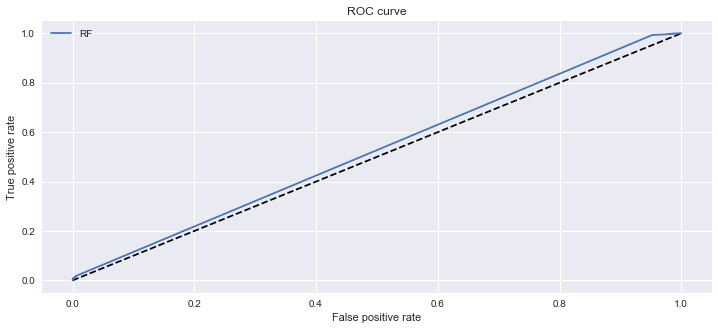

AUC: 0.53
precision [0.33377837 0.33368941 0.33373397 0.33377855 0.33382314 0.33386774
 0.33391235 0.33395697 0.3340016  0.33404625 0.33409091 0.33413558
 0.33422496 0.33426966 0.33431438 0.33435911 0.33440385 0.33444861
 0.33449337 0.33453815 0.33458294 0.33462775 0.33471739 0.33480707
 0.33485194 0.33489681 0.3349417  0.33503151 0.33507643 0.33516631
 0.33521127 0.33525624 0.33543624 0.33548127 0.33539205 0.33543709
 0.3355272  0.33557227 0.33561736 0.33566246 0.33575269 0.33579782
 0.33584297 0.33597848 0.33602368 0.3361141  0.33602476 0.33606999
 0.33611522 0.33607109 0.33616162 0.3362069  0.33625219 0.33616276
 0.33620806 0.33625337 0.33629869 0.33634403 0.33638938 0.33643474
 0.3366163  0.33666172 0.3365722  0.33661763 0.33666307 0.33670852
 0.33675398 0.33684495 0.33689045 0.33693596 0.33698149 0.33680227
 0.33693889 0.33698445 0.33703002 0.33707561 0.33712121 0.33721245
 0.33725809 0.33730374 0.3373494  0.33739507 0.33748646 0.33753217
 0.33757789 0.33762363 0.33771514 0.337760

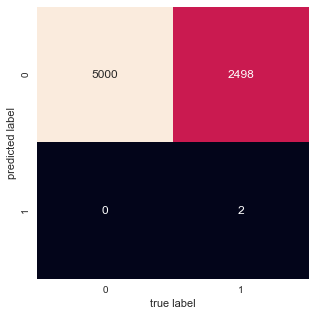

In [28]:
runSVM(X_train, y_train, X_test, y_test)

In [29]:
def runGaussianNB(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.naive_bayes import GaussianNB

    # Initialize our classifier
    model = GaussianNB()
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Test set Accuracy:     0.77
------
Train set Accuracy:     0.77
F1:           [0.84297371 0.56372796]
F1(macro):    0.70
F1(weighted): 0.75
[[4649  351]
 [1381 1119]]


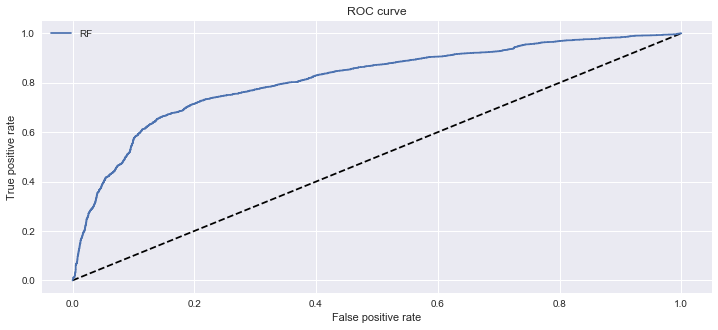

AUC: 0.81
precision [0.33351121 0.33342228 0.33346677 ... 0.78947368 0.77777778 1.        ]
recall [1.     0.9996 0.9996 ... 0.006  0.0056 0.    ]
recall_score <function recall_score at 0x10d61c840>
precision_score <function precision_score at 0x10d61c7b8>


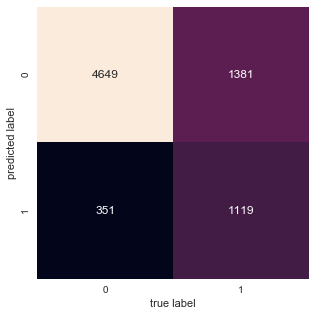

In [30]:
runGaussianNB(X_train, y_train, X_test, y_test)

In [31]:
def runLog(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.linear_model import LogisticRegression
    # Initialize our classifier
    model = LogisticRegression()
    model.fit(X_train_p, y_train_p)
    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)

Test set Accuracy:     0.80
------
Train set Accuracy:     0.79
F1:           [0.84879725 0.64986737]
F1(macro):    0.75
F1(weighted): 0.78
[[4446  554]
 [1030 1470]]


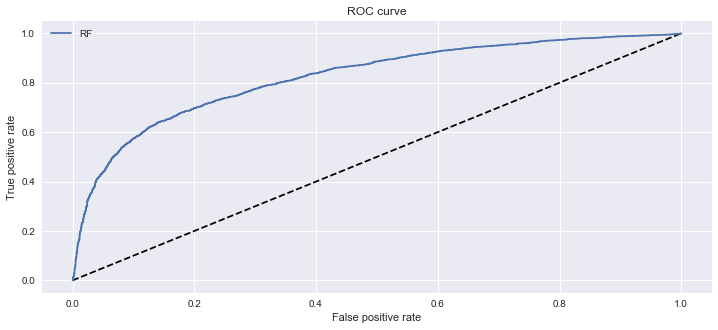

AUC: 0.82
precision [0.33333333 0.33324443 0.33315551 ... 1.         1.         1.        ]
recall [1.000e+00 9.996e-01 9.992e-01 ... 8.000e-04 4.000e-04 0.000e+00]
recall_score <function recall_score at 0x10d61c840>
precision_score <function precision_score at 0x10d61c7b8>


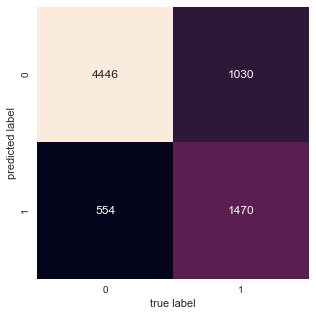

In [32]:
runLog(X_train, y_train, X_test, y_test)

In [33]:
def runRandom(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.ensemble import RandomForestClassifier    # Initialize our classifier
    model = RandomForestClassifier(random_state = 42)
    rf_enc = OneHotEncoder()
    model.fit(X_train_p, y_train_p)
    rf_enc.fit(model.apply(X_train_p))

    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 


    
    printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    base_accuracy = evaluate(model, X_test_p, y_test_p)
    print(base_accuracy)
   
    return model,base_accuracy

Test set Accuracy:     0.99
------
Train set Accuracy:     0.93
F1:           [0.9468137  0.88533558]
F1(macro):    0.92
F1(weighted): 0.93
[[4851  149]
 [ 396 2104]]


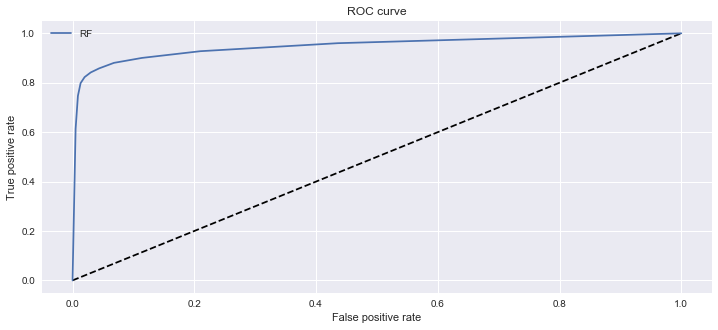

AUC: 0.95
precision [0.33333333 0.5242464  0.68833482 0.79794399 0.86619441 0.90774439
 0.93386596 0.95408163 0.96799224 0.97697541 0.98395379 1.        ]
recall [1.     0.96   0.9276 0.9004 0.8804 0.858  0.8416 0.8228 0.7984 0.7468
 0.6132 0.    ]
recall_score <function recall_score at 0x10d61c840>
precision_score <function precision_score at 0x10d61c7b8>
Model Performance
Average Error: 0.0727 degrees.
Accuracy = -inf%.
-inf


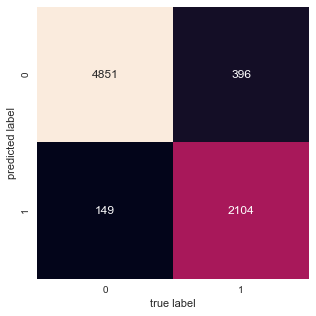

In [34]:
randForest_model,base_accuracy = runRandom(X_train, y_train, X_test, y_test)

In [35]:
#code source: https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

In [36]:
#code source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [37]:
def runRandomGrid(X_train_p, y_train_p, X_test_p, y_test_p, base_accuracy):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]
    }
    model = RandomForestRegressor(random_state = 42)
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

    grid_search.fit(X_train_p, y_train_p)
    print(grid_search.best_params_)

    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, X_test_p, y_test_p)

    print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


    
    #printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    
   
    return model, grid_search.best_params_

In [38]:
randForest_model, best_fit_rf = runRandomGrid(X_train, y_train, X_test, y_test, base_accuracy)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_s

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.9s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.6s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   9.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   9.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3,

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min


[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_s

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   2.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_sa

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_sam

[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   8.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_sa

[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   8.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_sam

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=  10.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   2.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   3.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   3.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   2.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   9.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.0s
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   8.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.5s
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   8.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   7.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.5s
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=  10.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_f

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.0min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   8.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   8.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   7.4s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   7.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   2.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   8.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   3.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   3.1s
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fe

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   3.2s
[CV] bootstrap=True, max_depth=110, max_f

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.2s
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   3.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  6.9min finished


{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
Model Performance
Average Error: 0.1167 degrees.
Accuracy = -inf%.
Improvement of nan%.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

In [39]:
# best_fit_rf={'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}

In [70]:
def runRandom_best(X_train_p, y_train_p, X_test_p, y_test_p):
    from sklearn.ensemble import RandomForestClassifier    # Initialize our classifier
    model = RandomForestClassifier(random_state = 42,**best_fit_rf)
    rf_enc = OneHotEncoder()
    model.fit(X_train_p, y_train_p)
    rf_enc.fit(model.apply(X_train_p))

    y_train_pred = model.predict(X_train_p)
    y_pred = model.predict(X_test_p) 


    
    fpr_rf, tpr_rf, threshold = printMetric(model, X_train_p, y_train_p, X_test_p, y_test_p, y_train_pred, y_pred)    
    base_accuracy = evaluate(model, X_test_p, y_test_p)
    print(base_accuracy)
   
    return model,base_accuracy, fpr_rf, tpr_rf, threshold

Test set Accuracy:     0.95
------
Train set Accuracy:     0.93
F1:           [0.95149217 0.89412264]
F1(macro):    0.92
F1(weighted): 0.93
[[4894  106]
 [ 393 2107]]


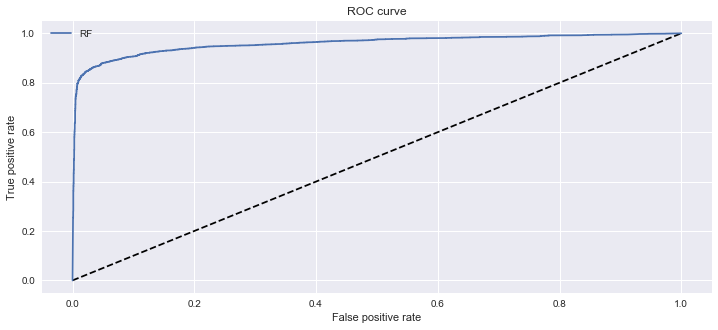

AUC: 0.96
precision [0.33333333 0.33839274 0.33857627 ... 0.99489796 0.99473684 1.        ]
recall [1.     0.9988 0.9988 ... 0.078  0.0756 0.    ]
recall_score [0.9788 0.8428]
precision_score [0.92566673 0.95210122]
Model Performance
Average Error: 0.0665 degrees.
Accuracy = -inf%.
-inf


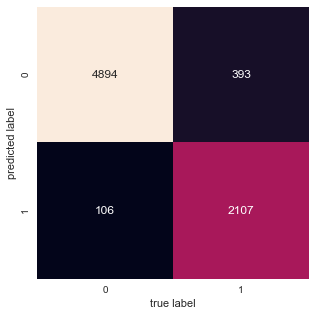

In [71]:
randForest_best_model,best_grid_accuracy, fpr, tpr, thr = runRandom_best(X_train, y_train, X_test, y_test)

In [72]:
fpr, tpr, thr

(array([0.000e+00, 2.000e-04, 2.000e-04, ..., 9.756e-01, 9.764e-01,
        1.000e+00]),
 array([0.    , 0.0756, 0.078 , ..., 0.9988, 0.9988, 1.    ]),
 array([2.00000000e+00, 1.00000000e+00, 9.99814815e-01, ...,
        5.26315789e-04, 1.22699387e-04, 0.00000000e+00]))

array([ True,  True, False, ..., False, False, False])

In [104]:
def RunThreadhold(t):
    change_t_y_predict = (randForest_best_model.predict_proba(X_test)[:,1] > t)
    change_t_y_predict
    mit_tr = confusion_matrix(y_test, change_t_y_predict)
    sns.heatmap(mit_tr.T, square=True, annot=True, fmt='d', cbar=False)
    from sklearn.metrics import recall_score, precision_score
    re_score = recall_score(y_test, change_t_y_predict, average=None)
    #print("recall_score %s" % re_score)
    pr_score = precision_score(y_test, change_t_y_predict, average=None)

    #print("precision_score %s" % pr_score)
    result =  {"recall": re_score[1],"precision": pr_score[1], "threshold": t}
    print(result)
    return result;



In [ ]:
[RunThreadhold(i) for i in thr]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'recall': 0.0, 'precision': 0.0, 'threshold': 2.0}
{'recall': 0.0, 'precision': 0.0, 'threshold': 1.0}
{'recall': 0.0756, 'precision': 0.9947368421052631, 'threshold': 0.9998148148148148}
{'recall': 0.0784, 'precision': 0.9949238578680203, 'threshold': 0.9997727272727274}
{'recall': 0.0788, 'precision': 0.9949494949494949, 'threshold': 0.9996153846153846}
{'recall': 0.0804, 'precision': 0.995049504950495, 'threshold': 0.9996107331821618}
{'recall': 0.0808, 'precision': 0.9950738916256158, 'threshold': 0.9995833333333334}
{'recall': 0.0832, 'precision': 0.9952153110047847, 'threshold': 0.9993333333333334}
{'recall': 0.0848, 'precision': 0.9953051643192489, 'threshold': 0.9992857142857143}
{'recall': 0.0884, 'precision': 0.9954954954954955, 'threshold': 0.9991666666666668}
{'recall': 0.0888, 'precision': 0.9955156950672646, 'threshold': 0.9991666666666665}
{'recall': 0.09, 'precision': 0.995575221238938, 'threshold': 0.999090909090909}
{'recall': 0.0936, 'precision': 0.9957446808510638,

{'recall': 0.2388, 'precision': 0.995, 'threshold': 0.9930130718954249}
{'recall': 0.2392, 'precision': 0.9950083194675541, 'threshold': 0.9929893162393162}
{'recall': 0.2432, 'precision': 0.9934640522875817, 'threshold': 0.9925833333333333}
{'recall': 0.2436, 'precision': 0.9934747145187602, 'threshold': 0.9925482295482294}
{'recall': 0.2448, 'precision': 0.9935064935064936, 'threshold': 0.992529761904762}
{'recall': 0.2452, 'precision': 0.993517017828201, 'threshold': 0.9925}
{'recall': 0.246, 'precision': 0.9935379644588045, 'threshold': 0.9924880952380951}
{'recall': 0.2464, 'precision': 0.9935483870967742, 'threshold': 0.9924242424242423}
{'recall': 0.2504, 'precision': 0.9936507936507937, 'threshold': 0.9922222222222223}
{'recall': 0.2508, 'precision': 0.993660855784469, 'threshold': 0.9922222222222221}
{'recall': 0.2516, 'precision': 0.9936808846761453, 'threshold': 0.9921847335990543}
{'recall': 0.252, 'precision': 0.9936908517350158, 'threshold': 0.9921428571428572}
{'recall':

{'recall': 0.4868, 'precision': 0.991042345276873, 'threshold': 0.9733170995670996}
{'recall': 0.4872, 'precision': 0.9910496338486574, 'threshold': 0.9733008658008658}
{'recall': 0.4904, 'precision': 0.9903069466882067, 'threshold': 0.972819264069264}
{'recall': 0.4908, 'precision': 0.9903147699757869, 'threshold': 0.9728156565656565}
{'recall': 0.4908, 'precision': 0.989516129032258, 'threshold': 0.9727442279942281}
{'recall': 0.4912, 'precision': 0.9895245769540693, 'threshold': 0.9727134591128399}
{'recall': 0.526, 'precision': 0.990210843373494, 'threshold': 0.9680362978524742}
{'recall': 0.5264, 'precision': 0.9902182091798345, 'threshold': 0.968024309024309}
{'recall': 0.5312, 'precision': 0.9895678092399404, 'threshold': 0.9676338383838383}
{'recall': 0.5316, 'precision': 0.9895755770662695, 'threshold': 0.9676333309077115}
{'recall': 0.5336, 'precision': 0.9896142433234422, 'threshold': 0.9673132284382284}
{'recall': 0.534, 'precision': 0.9896219421793921, 'threshold': 0.96719

{'recall': 0.8156, 'precision': 0.9718779790276454, 'threshold': 0.6696623099123096}
{'recall': 0.816, 'precision': 0.9718913768461171, 'threshold': 0.6660369769119768}
{'recall': 0.8164, 'precision': 0.97144217039505, 'threshold': 0.6630311077811076}
{'recall': 0.8168, 'precision': 0.9714557564224549, 'threshold': 0.6627952997295102}
{'recall': 0.8176, 'precision': 0.971021377672209, 'threshold': 0.6519412034044386}
{'recall': 0.818, 'precision': 0.9710351377018044, 'threshold': 0.6518872238872242}
{'recall': 0.8184, 'precision': 0.9705882352941176, 'threshold': 0.6489071067821068}
{'recall': 0.8188, 'precision': 0.9701421800947867, 'threshold': 0.6439062832592244}
{'recall': 0.8192, 'precision': 0.9696969696969697, 'threshold': 0.6398779264680965}
{'recall': 0.8196, 'precision': 0.9697113109323237, 'threshold': 0.6397010212010211}
{'recall': 0.8216, 'precision': 0.9693251533742331, 'threshold': 0.624206598956599}
{'recall': 0.822, 'precision': 0.9688826025459689, 'threshold': 0.62061

{'recall': 0.8572, 'precision': 0.9325500435161009, 'threshold': 0.41947102897102906}
{'recall': 0.8576, 'precision': 0.9321739130434783, 'threshold': 0.4179697508373979}
{'recall': 0.858, 'precision': 0.9322033898305084, 'threshold': 0.41767085692085687}
{'recall': 0.8588, 'precision': 0.9318576388888888, 'threshold': 0.4158223056183582}
{'recall': 0.8592, 'precision': 0.9310793237971391, 'threshold': 0.414440879382056}
{'recall': 0.86, 'precision': 0.9307359307359307, 'threshold': 0.41253384596999143}
{'recall': 0.8604, 'precision': 0.9291576673866091, 'threshold': 0.40922632922632934}
{'recall': 0.8604, 'precision': 0.9287564766839378, 'threshold': 0.40783046120546124}
{'recall': 0.8608, 'precision': 0.9287872248597324, 'threshold': 0.4074351947072536}
{'recall': 0.8612, 'precision': 0.9284174213022854, 'threshold': 0.40484948221712924}
{'recall': 0.8616, 'precision': 0.9272492466637968, 'threshold': 0.40095985958485975}
{'recall': 0.862, 'precision': 0.9268817204301075, 'threshold'

{'recall': 0.8856, 'precision': 0.8789202064311235, 'threshold': 0.3091266650016651}
{'recall': 0.886, 'precision': 0.8779231074118113, 'threshold': 0.30786259646785974}
{'recall': 0.8864, 'precision': 0.8776237623762376, 'threshold': 0.30620387945387934}
{'recall': 0.8868, 'precision': 0.8773248911753067, 'threshold': 0.3056570651570652}
{'recall': 0.8868, 'precision': 0.8769778481012658, 'threshold': 0.3054191617206323}
{'recall': 0.8872, 'precision': 0.8770264926848557, 'threshold': 0.30456594059535236}
{'recall': 0.8872, 'precision': 0.8766798418972332, 'threshold': 0.30413963813963824}
{'recall': 0.8876, 'precision': 0.87534516765286, 'threshold': 0.3033156288156288}
{'recall': 0.8876, 'precision': 0.875, 'threshold': 0.30221058181584504}
{'recall': 0.888, 'precision': 0.8750492707922743, 'threshold': 0.30134901266678754}
{'recall': 0.888, 'precision': 0.8747044917257684, 'threshold': 0.30119996914849856}
{'recall': 0.8884, 'precision': 0.8726915520628684, 'threshold': 0.297919289

{'recall': 0.9084, 'precision': 0.8119413657490168, 'threshold': 0.22681957122398294}
{'recall': 0.9084, 'precision': 0.811651179413867, 'threshold': 0.2267002980679451}
{'recall': 0.9088, 'precision': 0.811718470882458, 'threshold': 0.22669200325817965}
{'recall': 0.9092, 'precision': 0.8114958943234559, 'threshold': 0.22642554096230566}
{'recall': 0.9096, 'precision': 0.8101175632347702, 'threshold': 0.22577543126807836}
{'recall': 0.9096, 'precision': 0.8098290598290598, 'threshold': 0.22577410906087375}
{'recall': 0.91, 'precision': 0.8098967604129583, 'threshold': 0.22520093795093796}
{'recall': 0.9108, 'precision': 0.8097439544807966, 'threshold': 0.2246575091575091}
{'recall': 0.9112, 'precision': 0.8098115890508354, 'threshold': 0.22353508093213975}
{'recall': 0.9116, 'precision': 0.8095914742451155, 'threshold': 0.2233638064833716}
{'recall': 0.912, 'precision': 0.8096590909090909, 'threshold': 0.22311577311577305}
{'recall': 0.912, 'precision': 0.8093716719914803, 'threshold'

{'recall': 0.9328, 'precision': 0.7358788261281162, 'threshold': 0.15467411754911756}
{'recall': 0.9332, 'precision': 0.7354981084489282, 'threshold': 0.15455859272306638}
{'recall': 0.9332, 'precision': 0.7352663094862906, 'threshold': 0.1541142482859751}
{'recall': 0.9336, 'precision': 0.732120451693852, 'threshold': 0.1522255701814525}
{'recall': 0.9336, 'precision': 0.7318908748824082, 'threshold': 0.15189231601731598}
{'recall': 0.934, 'precision': 0.7306007509386734, 'threshold': 0.15091777666777662}


In [63]:
with open('randForest_best_model.pkl', 'wb') as picklefile:
    pickle.dump(randForest_best_model, picklefile)

In [43]:
X_train.columns[0]

'ip'

Feature ranking:
1. app (0.521212)
2. channel (0.207047)
3. ip (0.145181)
4. device (0.059769)
5. os (0.037473)
6. hour (0.029317)


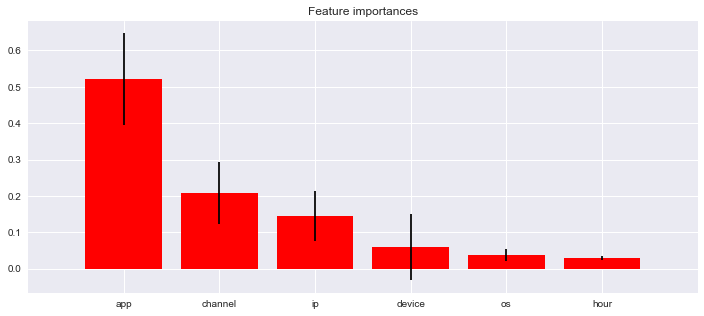

In [55]:
importances = randForest_best_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in randForest_best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
cols = [X_train.columns[indices[f]] for f in range(X.shape[1])]
for f in range(X.shape[1]):
    #print(X_train.columns[indices[f]])
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), cols)
plt.xlim([-1, X.shape[1]])
plt.show()

In [45]:
indices

array([1, 4, 0, 2, 3, 5])

In [46]:

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
train_pool = Pool(X_train,y_train)
cat_model = CatBoostClassifier(iterations=25, learning_rate=0.1)
cat_model.fit(train_pool, eval_set=(X_test, y_test),plot=True)


0:	learn: 0.6083648	test: 0.6085322	best: 0.6085322 (0)	total: 85.7ms	remaining: 2.06s
1:	learn: 0.5469088	test: 0.5468551	best: 0.5468551 (1)	total: 112ms	remaining: 1.29s
2:	learn: 0.4790434	test: 0.4787773	best: 0.4787773 (2)	total: 141ms	remaining: 1.03s
3:	learn: 0.4364716	test: 0.4359963	best: 0.4359963 (3)	total: 167ms	remaining: 877ms
4:	learn: 0.4034758	test: 0.4027177	best: 0.4027177 (4)	total: 193ms	remaining: 774ms
5:	learn: 0.3751320	test: 0.3732735	best: 0.3732735 (5)	total: 219ms	remaining: 694ms
6:	learn: 0.3533502	test: 0.3509191	best: 0.3509191 (6)	total: 246ms	remaining: 632ms
7:	learn: 0.3364820	test: 0.3340573	best: 0.3340573 (7)	total: 270ms	remaining: 573ms
8:	learn: 0.3210753	test: 0.3184631	best: 0.3184631 (8)	total: 296ms	remaining: 526ms
9:	learn: 0.3092049	test: 0.3064846	best: 0.3064846 (9)	total: 322ms	remaining: 484ms
10:	learn: 0.2980375	test: 0.2952287	best: 0.2952287 (10)	total: 347ms	remaining: 442ms
11:	learn: 0.2878602	test: 0.2850197	best: 0.285019

In [47]:
df_ad = pd.read_csv('data/test.csv')
df_ad

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00
5,5,110769,18,1,13,107,2017-11-10 04:00:00
6,6,12540,3,1,1,137,2017-11-10 04:00:00
7,7,88637,27,1,19,153,2017-11-10 04:00:00
8,9,14932,18,1,10,107,2017-11-10 04:00:00
9,8,123701,12,1,53,424,2017-11-10 04:00:00


In [48]:
def convertDF(df_old):
    df_old['click_time'] = pd.to_datetime(df_old['click_time'], format='%Y/%m/%d %H:%M:%S')
    df_old['hour']=df_old['click_time'].dt.hour
    df_old['date']=df_old['click_time'].dt.date
    df_old['day']=df_old['click_time'].dt.day
    df_old['month']=df_old['click_time'].dt.month
    df_old['year']=df_old['click_time'].dt.year
    return df_old

In [49]:
df_new = convertDF(df_ad)
df_new.head()

,click_id,ip,app,device,os,channel,click_time,hour,date,day,month,year
0,0,5744,9,1,3,107,2017-11-10 04:00:00,4,2017-11-10,10,11,2017
1,1,119901,9,1,3,466,2017-11-10 04:00:00,4,2017-11-10,10,11,2017
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4,2017-11-10,10,11,2017
3,3,78477,15,1,13,111,2017-11-10 04:00:00,4,2017-11-10,10,11,2017
4,4,123080,12,1,13,328,2017-11-10 04:00:00,4,2017-11-10,10,11,2017


In [50]:
x = df_new.loc[:, ['ip', 'app', 'device', 'os', 'channel', 'hour']]

In [51]:
sub_cat_2 = cat_model.predict(x)
sub_cat_2

array([0., 0., 0., ..., 0., 0., 0.])

In [56]:
df_new_sub = df_new

In [58]:
# len(df_new_sub['is_attributed']==1)

In [59]:
df_new_sub['is_attributed'] = sub_cat_2


In [60]:
df_new_sub = df_new_sub.drop(['ip', 'app', 'device', 'os', 'channel', 'click_time',
       'hour', 'date', 'day', 'month', 'year'], axis=1)

In [61]:
df_new_sub.to_csv('submission_second.csv', index=False)